# Forecast de Ventas 2026: Análisis por Tipo de Suscripción

**Objetivo:** Generar una proyección diaria de ventas (cantidad y/o ingresos) para el año 2026 basada en el histórico Agosto 2022 - Agosto 2025.

**Metodología:** Se utilizará el algoritmo **Prophet** (Meta), ideal para series de tiempo con fuerte estacionalidad y efectos de calendario.

**Datos de entrada:**
- Granularidad: Diaria
- Segmentación: `tipo_suscripcion`

In [177]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet

# Configuración visual para los gráficos
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
plt.rcParams['figure.figsize'] = (15, 6)

print("Librerías cargadas correctamente.")

Librerías cargadas correctamente.


In [178]:
# 1. Cargar el dataset
# Asegúrate de que el archivo esté en la misma carpeta o coloca la ruta completa
nombre_archivo = '../data/data_forecast_excesos_2025/data_excesos_sin_outliers.csv'  # <--- CAMBIA ESTO POR TU ARCHIVO REAL
df_main = pd.read_csv(nombre_archivo)

# 2. Conversión de fechas
df_main['fecha'] = pd.to_datetime(df_main['fecha'])

# 3. Verificación rápida
print(f"Rango de fechas: {df_main['fecha'].min()} a {df_main['fecha'].max()}")

display(df_main.head())

Rango de fechas: 2022-09-01 00:00:00 a 2025-11-01 00:00:00


,anio,mes,monto_sin_iva,mes_numero,fecha
0,2022,septiembre,261325.3793,9,2022-09-01
1,2022,octubre,353934.8793,10,2022-10-01
2,2022,noviembre,557951.5259,11,2022-11-01
3,2022,diciembre,554553.9569,12,2022-12-01
4,2023,enero,404493.4224,1,2023-01-01


In [179]:
# filtrar por año 2025
df_main = df_main[df_main['fecha'].dt.year <= 2025]

Filtro para obtener muestra de datos

c:\Users\victor.briones\Documents\python_virtual_enviroments\exploratory_data_analysis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
12:47:50 - cmdstanpy - INFO - Chain [1] start processing
12:47:51 - cmdstanpy - INFO - Chain [1] done processing


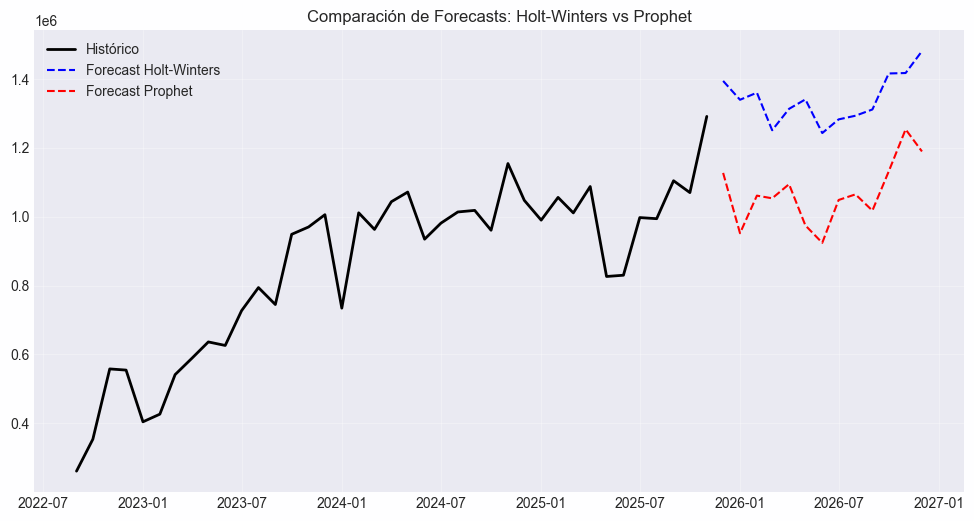

Pronóstico Holt-Winters:
2025-12-01    1393700.17
2026-01-01    1339047.17
2026-02-01    1359627.42
2026-03-01    1250672.70
2026-04-01    1312705.06
2026-05-01    1340089.28
2026-06-01    1242425.99
2026-07-01    1282114.47
2026-08-01    1292784.50
2026-09-01    1310877.08
2026-10-01    1415395.65
2026-11-01    1416649.19
2026-12-01    1480180.46
Freq: MS, dtype: float64

Pronóstico Prophet (últimos 13 meses):
                  yhat  yhat_lower  yhat_upper
ds                                            
2025-12-01  1126733.40  1056610.84  1197477.20
2026-01-01   951760.29   884719.83  1017346.14
2026-02-01  1060870.45   989939.22  1130475.98
2026-03-01  1053090.05   983492.08  1122114.80
2026-04-01  1094076.96  1025692.65  1160273.15
2026-05-01   974410.53   910647.14  1041766.45
2026-06-01   923896.24   850256.98   993666.44
2026-07-01  1048241.94   975792.39  1121472.37
2026-08-01  1064540.04   993337.04  1144370.95
2026-09-01  1017374.19   940120.25  1094743.08
2026-10-01  1131142.3

In [ ]:
# 1. Cargar y preparar los datos
df = df_main

# Crear una fecha legible para los modelos (Día 1 de cada mes)
meses = {
    'enero': '01', 'febrero': '02', 'marzo': '03', 'abril': '04',
    'mayo': '05', 'junio': '06', 'julio': '07', 'agosto': '08',
    'septiembre': '09', 'octubre': '10', 'noviembre': '11', 'diciembre': '12'
}

df['fecha_str'] = df['anio'].astype(str) + '-' + df['mes'].map(meses) + '-01'
df['fecha'] = pd.to_datetime(df['fecha_str'])
df = df.set_index('fecha').sort_index()

# Limpieza básica: El primer valor negativo puede ensuciar el modelo.
# Opción: Reemplazarlo con 0 o el siguiente valor positivo si es un error.
df.loc[df['monto_sin_iva'] < 0, 'monto_sin_iva'] = 0

# --- MODELO 1: Holt-Winters (Exponential Smoothing) ---
# Usamos tendencia y estacionalidad multiplicativa (12 meses)
hw_model = ExponentialSmoothing(
    df['monto_sin_iva'],
    trend='add',
    seasonal='mul',
    seasonal_periods=13
).fit()

# Pronóstico a 13 meses
hw_forecast = hw_model.forecast(13)

# --- MODELO 2: Prophet ---
# Prophet requiere columnas específicas: 'ds' (fecha) y 'y' (valor)
df_prophet = df.reset_index()[['fecha', 'monto_sin_iva']].rename(columns={'fecha': 'ds', 'monto_sin_iva': 'y'})

m = Prophet(seasonality_mode='multiplicative') 
m.fit(df_prophet)

future = m.make_future_dataframe(periods=13, freq='MS') # 13 meses a futuro
prophet_forecast = m.predict(future)

# --- GRAFICAR RESULTADOS ---
plt.figure(figsize=(12, 6))

# Datos históricos
plt.plot(df.index, df['monto_sin_iva'], label='Histórico', color='black', linewidth=2)

# Holt-Winters
plt.plot(hw_forecast.index, hw_forecast, label='Forecast Holt-Winters', linestyle='--', color='blue')

# Prophet (solo la parte futura)
prophet_future = prophet_forecast.tail(13)
plt.plot(prophet_future['ds'], prophet_future['yhat'], label='Forecast Prophet', linestyle='--', color='red')

plt.title('Comparación de Forecasts: Holt-Winters vs Prophet')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Ver los valores numéricos del forecast
print("Pronóstico Holt-Winters:")
print(hw_forecast.round(2))
print("\nPronóstico Prophet (últimos 13 meses):")
print(prophet_future[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].set_index('ds').round(2))

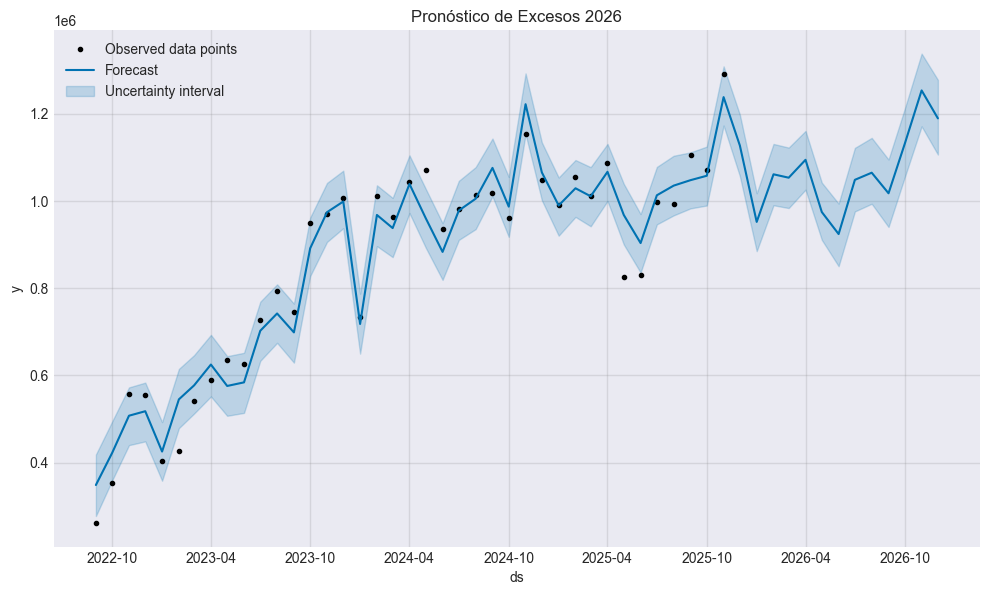

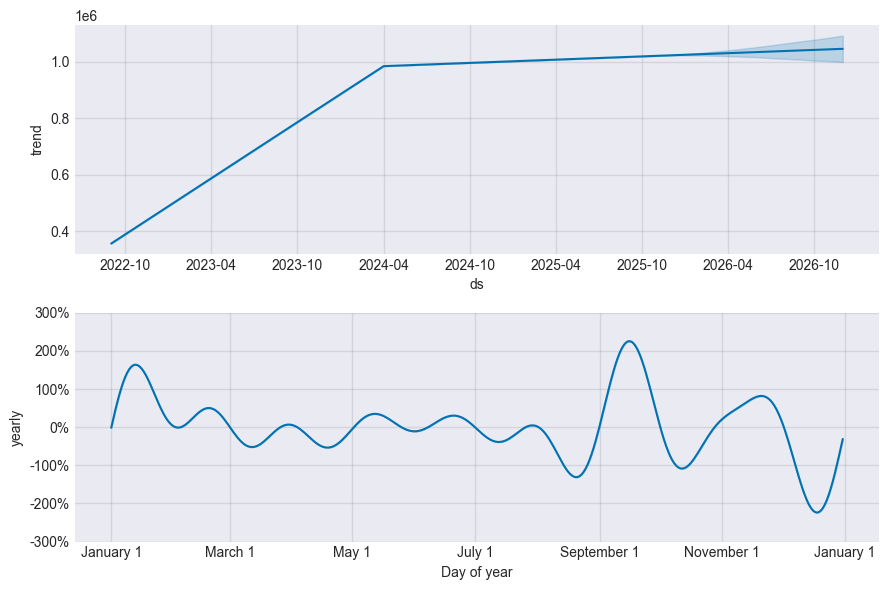

In [183]:
# 1. Gráfico principal: Puntos negros son datos reales, línea azul es la predicción
fig1 = m.plot(prophet_forecast)
plt.title("Pronóstico de Excesos 2026")
# mostrar leyenda
plt.legend()
plt.show()

# 2. Desglose de componentes: Muestra Tendencia, Semanal, Anual y Festivos por separado
fig2 = m.plot_components(prophet_forecast)
plt.show()

In [182]:
prophet_future[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('../data/data_forecast_excesos_2025/prophet_forecast_excesos_2026.csv', index=False)